### Benchmark SeismicPro methods

| Function Name| Optimal target | Link |
| :---:        | :----: |  :---:|
|*__BATCH__*|||
| \_load_gather | for |[_load_gather](#load_gather)|
| \_load_combined_gather | for |  [_load_combined_gather](#load_combined_gather)|
|*__GATHER__*|||
| copy | threads | [copy](#copy) |
| get_item | for | [get_item](#get_item) |
| dump | for | [dump](#dump) |
| sort | for | [sort](#sort) |
| pick_to_mask | threads | [pick_to_mask](#pick_to_mask) |
| mask_to_pick | for | [mask_to_pick](#mask_to_pick) |
| mute | threads | [mute](#mute) |
| calculate_semblance | threads | [calculate_semblance](#calculate_semblance) |
| calculate_residual_semblance | threads | [calculate_residual_semblance](#calculate_residual_semblance) |
| get_central_cdp | for | [get_central_cdp](#get_central_cdp) |
| apply_nmo | threads | [apply_nmo](#apply_nmo) |
| stack | for | [stack](#stack) |
| scale_standard | threads | [scale_standard](#scale_standard) |
| scale_maxabs | threads | [scale_maxabs](#scale_maxabs) |
| scale_minmax | threads | [scale_minmax](#scale_minmax) |
| crop | for | [crop](#crop) |
| apply_agc | for | [apply_agc](#apply_agc) |
| apply_sdc | for | [apply_sdc](#apply_sdc) |
|*__SEMBLANCE__*|||
| calculate_stacking_velocity | for | [calculate_stacking_velocity](#calculate_stacking_velocity) |
|*__CROPPED GATHER__*|||
| assemble_gather | threads | [assemble_gather](#assemble_gather) |


All results are obtained for the following configuration:
* CPU - Intel(R) Xeon(R) Gold 6242R CPU @ 3.10GHz x 20
* 512 Gb RAM

In [1]:
import os
import sys
import dill
import tempfile

import numpy as np

sys.path.insert(0, '../..')
from seismicpro import SeismicDataset, Muter, StackingVelocity
from seismicpro.src.const import DEFAULT_STACKING_VELOCITY
from seismicpro.batchflow import Pipeline

from benchmark import Benchmark
from utils import make_benchmark_data

Define constants

In [2]:
BATCH_SIZES = list(range(1, 11)) + list(range(20, 51, 10))
N_ITERS = 10
TARGETS = ('for', 'threads')
SHUFFLE = 42

stacking_velocity = DEFAULT_STACKING_VELOCITY

Create temporary folder to store benchmark data and generate paths

In [3]:
tmp_dir = tempfile.TemporaryDirectory()
DATA_PATH = os.path.join(tmp_dir.name, 'benchmark_data.sgy')
DUMP_PATH = os.path.join(tmp_dir.name, 'dump')

Create survey and the dataset

In [4]:
survey, supergather_survey = make_benchmark_data(DATA_PATH)

Common shot gathers generated:   0%|          | 0/6400 [00:00<?, ?it/s]

Trace headers loaded:   0%|          | 0/2464900 [00:00<?, ?it/s]

In [5]:
dataset = SeismicDataset(surveys=survey)
supergather_dataset = SeismicDataset(surveys=supergather_survey)

load_pipeline = Pipeline().load(src='raw', fmt='sgy')
sort_pipeline = load_pipeline + Pipeline().sort(src='raw', by='offset')

In [6]:
default_kwargs = dict(targets=TARGETS, batch_sizes=BATCH_SIZES, dataset=dataset)

supergather_kwargs = default_kwargs.copy()
supergather_kwargs.update(dataset=supergather_dataset)

long_running_kwargs = default_kwargs.copy()
long_running_kwargs.update(batch_sizes=BATCH_SIZES[:-3])

### load_gather

100%|██████████| 28/28 [00:50<00:00,  1.81s/it]


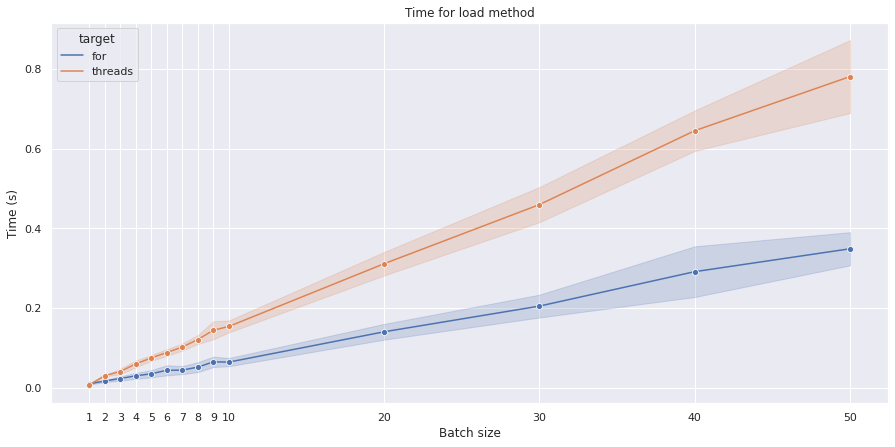

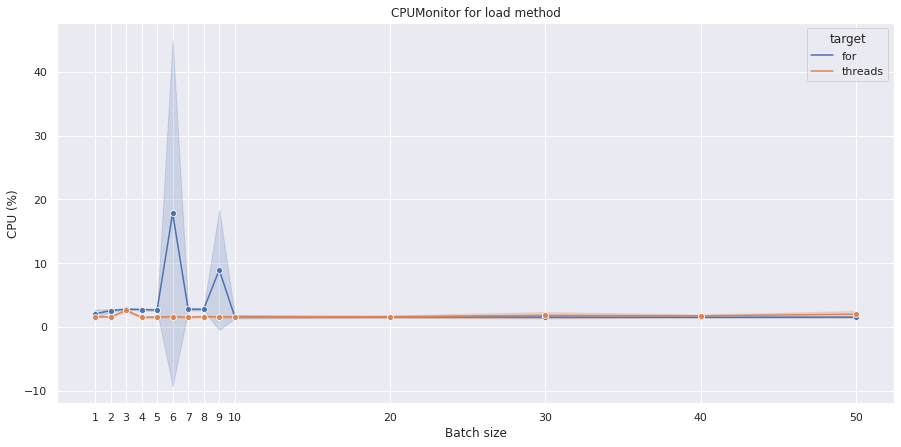

In [7]:
load_bm = Benchmark(method_name='load', method_kwargs={'src':'raw'},
                    root_pipeline=None, **default_kwargs)

load_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### load_combined_gather

0it [00:52, ?it/s]/28 [00:00<00:10,  2.45it/s]
100%|██████████| 28/28 [00:42<00:00,  1.50s/it]


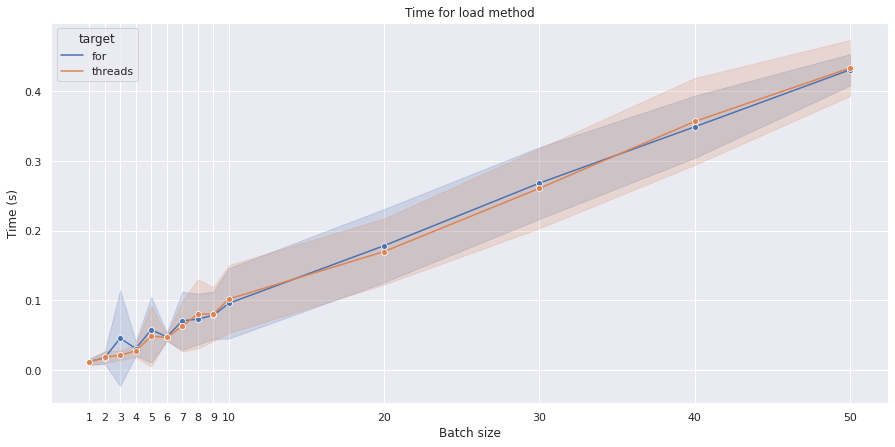

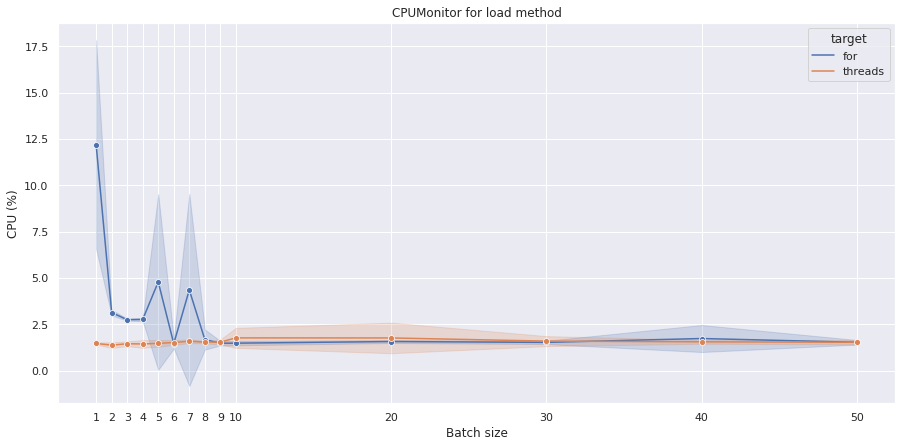

In [8]:
load_comb_bm = Benchmark(method_name='load', method_kwargs={'src':'raw', 'combined': True},
                         root_pipeline=None, **default_kwargs)

load_comb_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### copy

0it [00:50, ?it/s]/28 [00:06<00:14,  1.30it/s]
100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


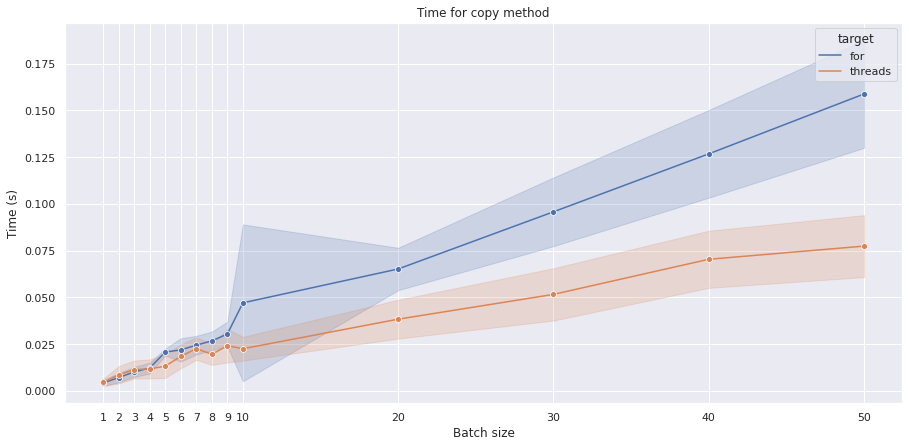

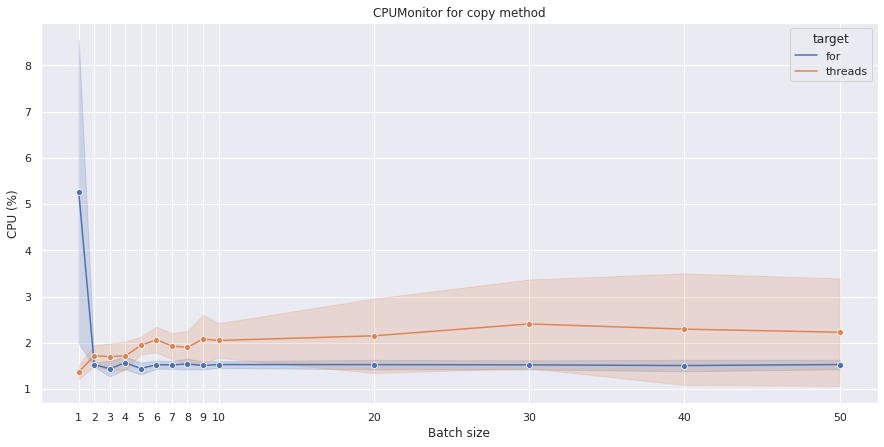

In [9]:
copy_bm = Benchmark(method_name='copy', method_kwargs={'src':'raw', 'dst':'rawraw'},
                    root_pipeline=load_pipeline, **default_kwargs)

copy_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### get_item

0it [01:12, ?it/s]4/28 [00:24<00:04,  1.04s/it]
100%|██████████| 28/28 [00:37<00:00,  1.35s/it]


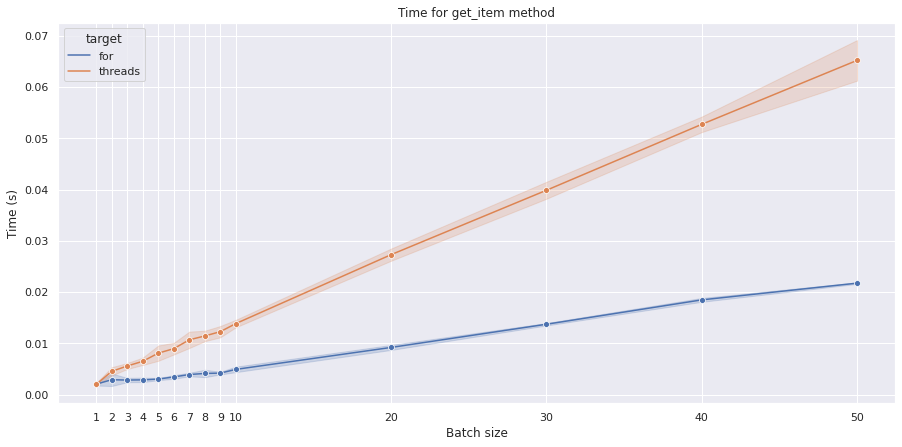

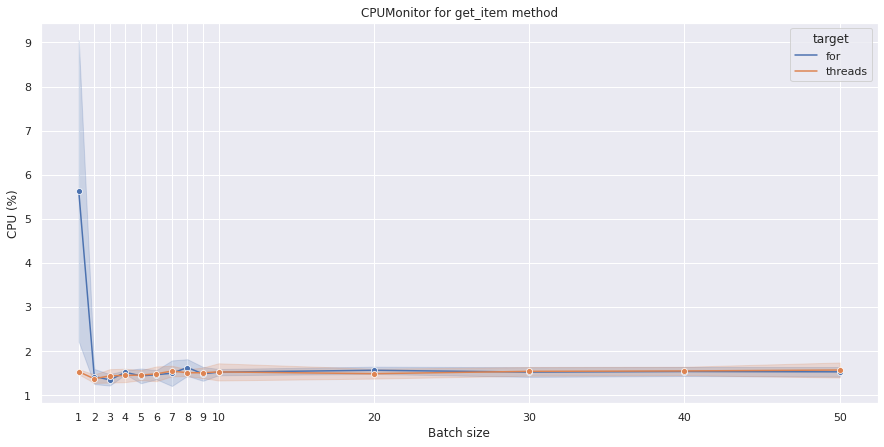

In [10]:
get_item_bm = Benchmark(method_name='get_item', method_args=([1, 2, 5], ), method_kwargs={'src':'raw'},
                    root_pipeline=load_pipeline, **default_kwargs)

get_item_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### dump

0it [00:50, ?it/s]/28 [00:08<00:40,  1.76s/it]
100%|██████████| 28/28 [05:27<00:00, 11.71s/it]


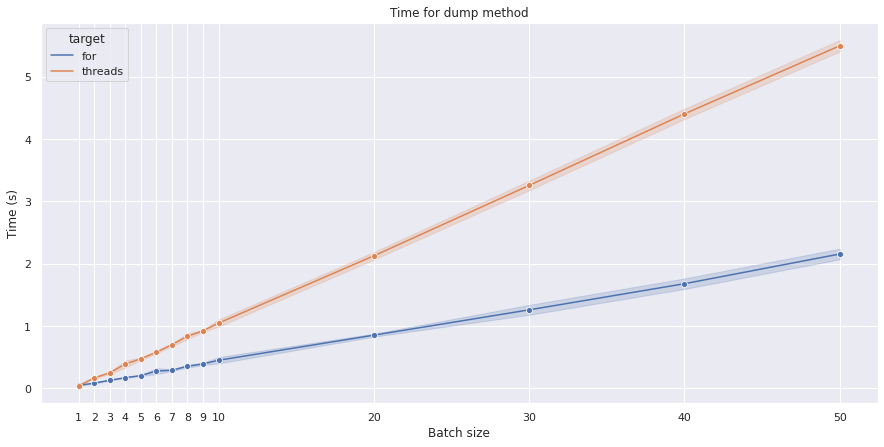

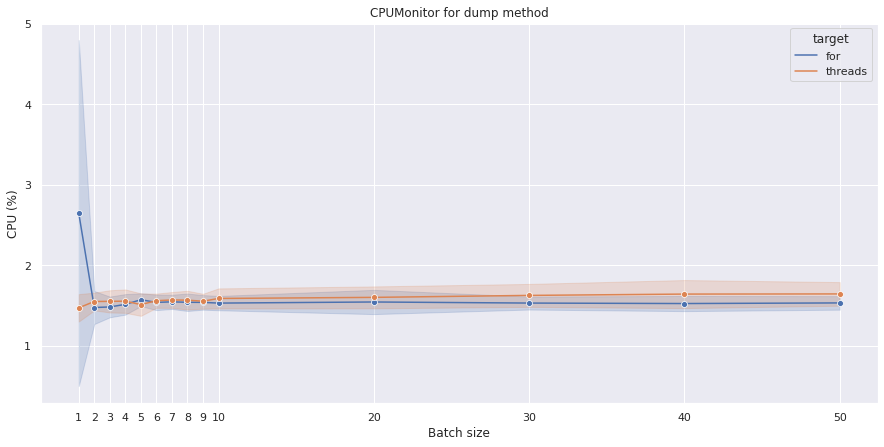

In [11]:
dump_bm = Benchmark(method_name='dump', method_kwargs={'src':'raw', 'path':DUMP_PATH},
                    root_pipeline=load_pipeline, **default_kwargs)

dump_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### sort

0it [05:49, ?it/s]3/28 [00:16<00:19,  1.28s/it]
100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


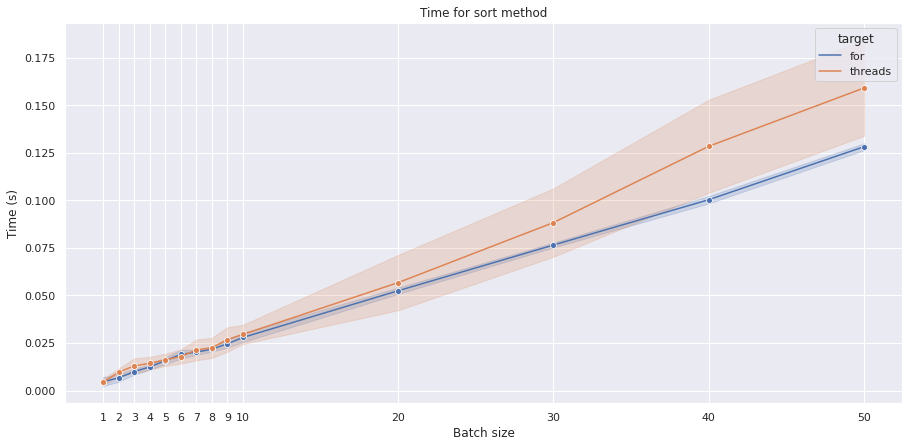

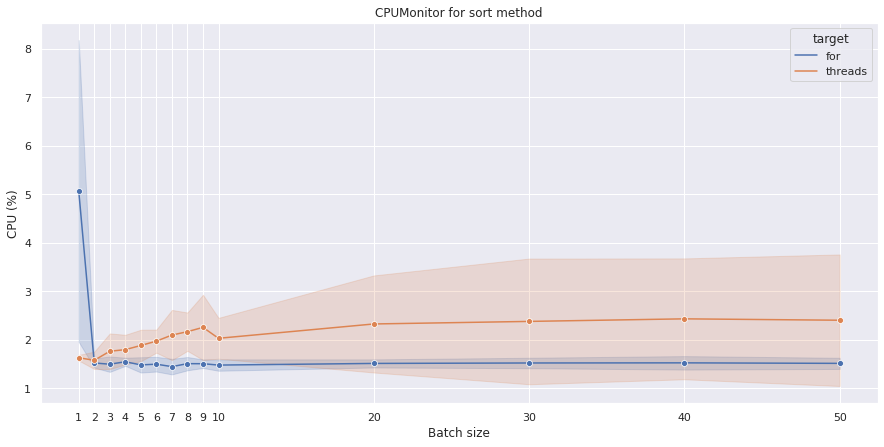

In [12]:
sort_bm = Benchmark(method_name='sort', method_kwargs={'src':'raw', 'by':'offset'},
                    root_pipeline=load_pipeline, **default_kwargs)

sort_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### pick_to_mask

0it [00:46, ?it/s]
100%|██████████| 28/28 [00:46<00:00,  1.66s/it]
0it [00:47, ?it/s]


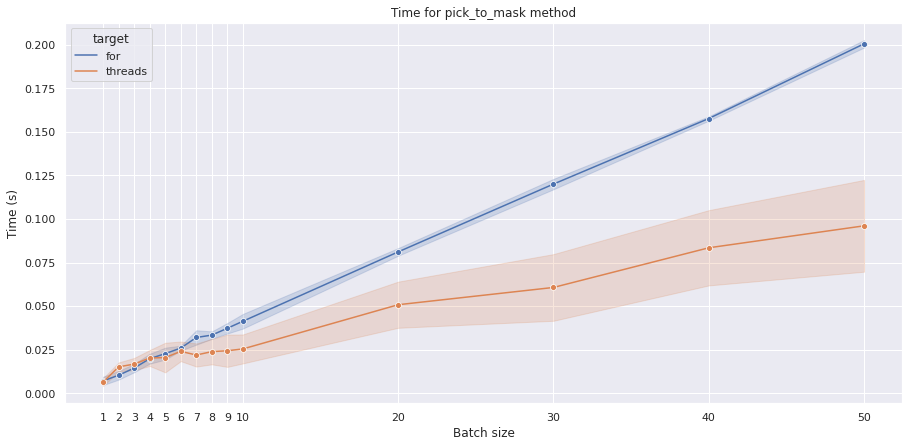

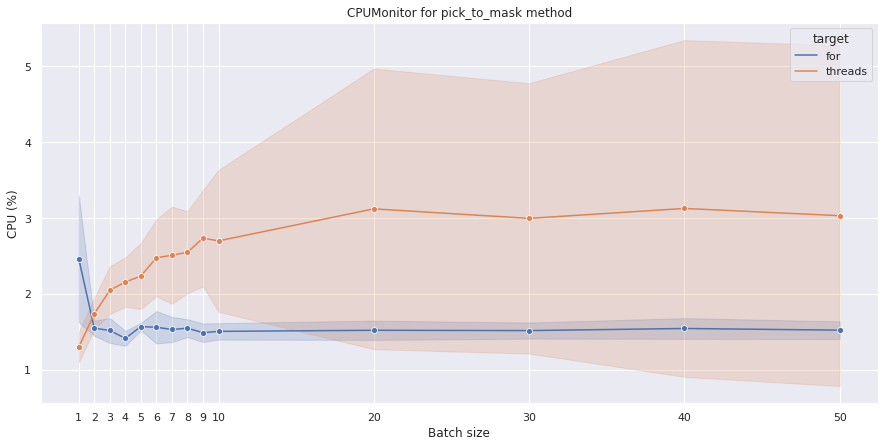

In [13]:
pcik_to_mask_bm = Benchmark(method_name='pick_to_mask', method_kwargs={'src':'raw'},
                            root_pipeline=load_pipeline, **default_kwargs)

pcik_to_mask_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### mask_to_pick

100%|██████████| 28/28 [00:59<00:00,  2.11s/it]


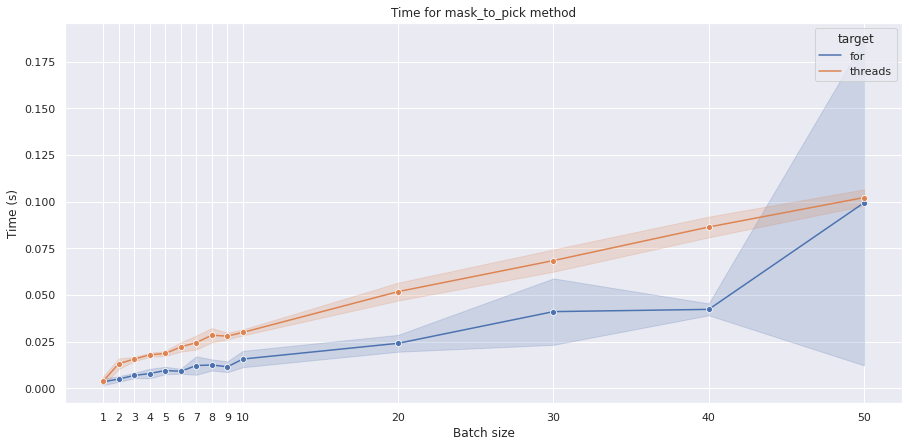

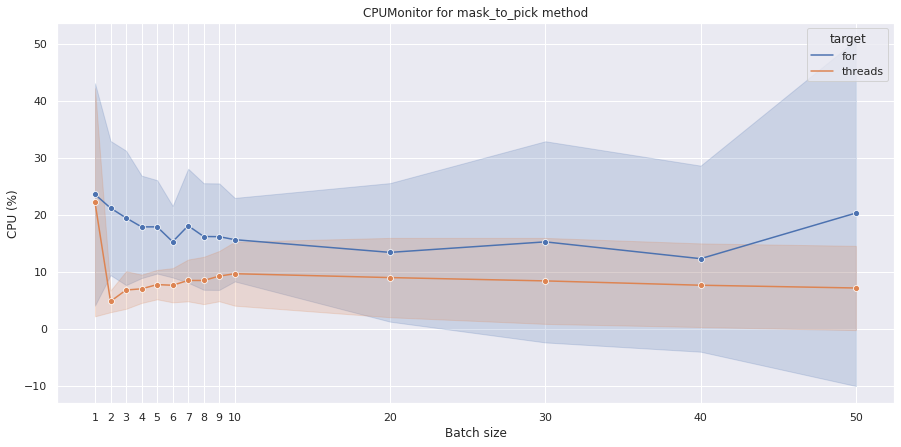

In [14]:
mask_to_pick_ppl = load_pipeline + Pipeline().pick_to_mask(src='raw')
mask_to_pick_bm = Benchmark(method_name='mask_to_pick', method_kwargs={'src':'raw', 'threshold':0.5},
                            root_pipeline=mask_to_pick_ppl, **default_kwargs)

mask_to_pick_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### mute

0it [01:00, ?it/s]
100%|██████████| 28/28 [01:01<00:00,  2.19s/it]


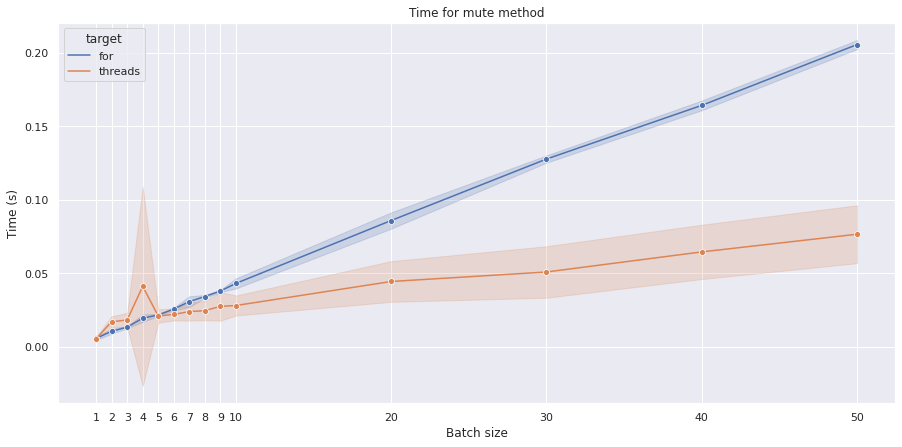

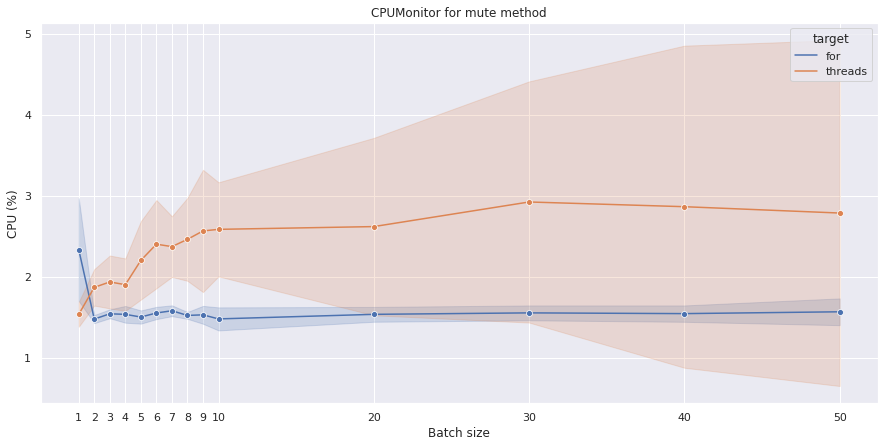

In [15]:
muter = Muter.from_points(offsets=[1000, 2000, 3000], times=[100, 300, 600])
mute_bm = Benchmark(method_name='mute', method_kwargs={'src': 'raw', 'muter': muter},
                    root_pipeline=load_pipeline, **default_kwargs)

mute_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_semblance

0it [01:02, ?it/s]
100%|██████████| 22/22 [40:54<00:00, 111.57s/it]


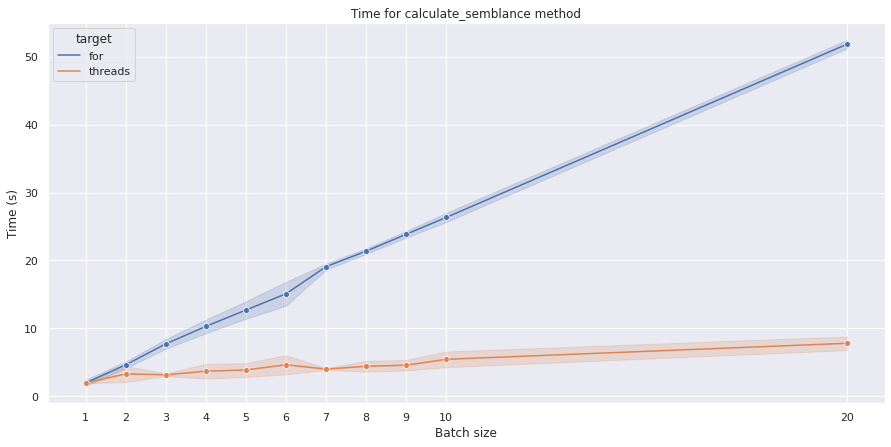

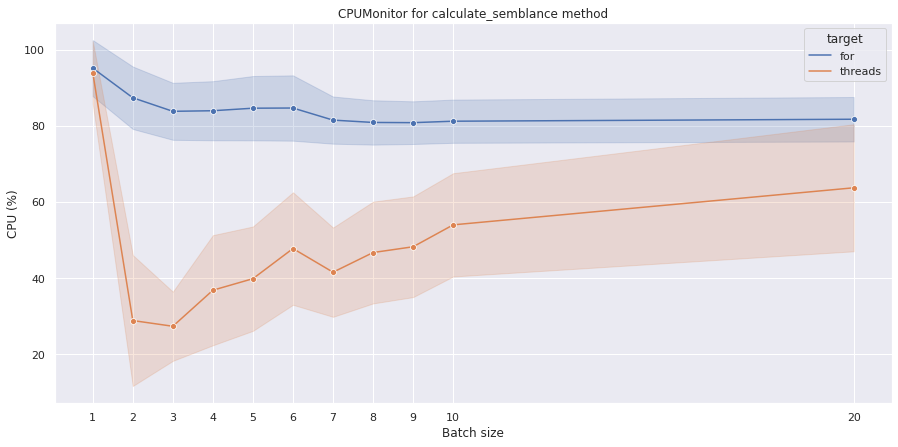

In [16]:
semblance_kwargs = {'src': 'raw', 'velocities': np.linspace(1300, 5500, 140), 'win_size': 25}
semblance_bm = Benchmark(method_name='calculate_semblance', method_kwargs=semblance_kwargs,
                         root_pipeline=sort_pipeline, **long_running_kwargs)

semblance_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_residual_semblance

0it [40:56, ?it/s]
100%|██████████| 22/22 [15:40<00:00, 42.75s/it]


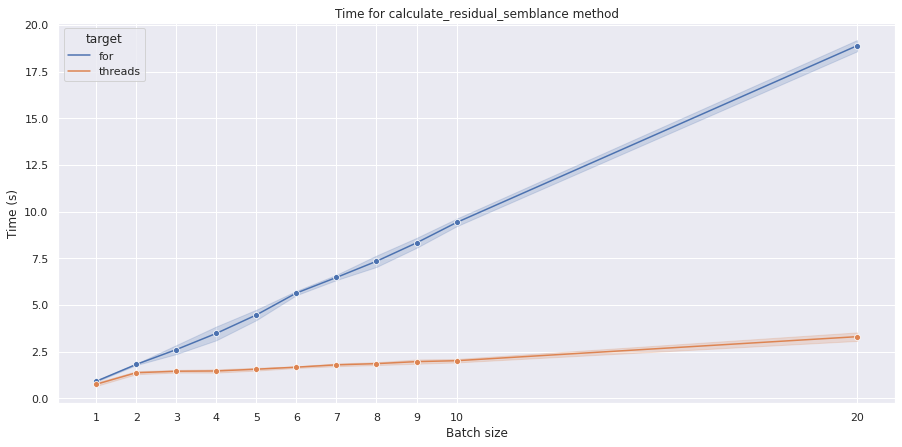

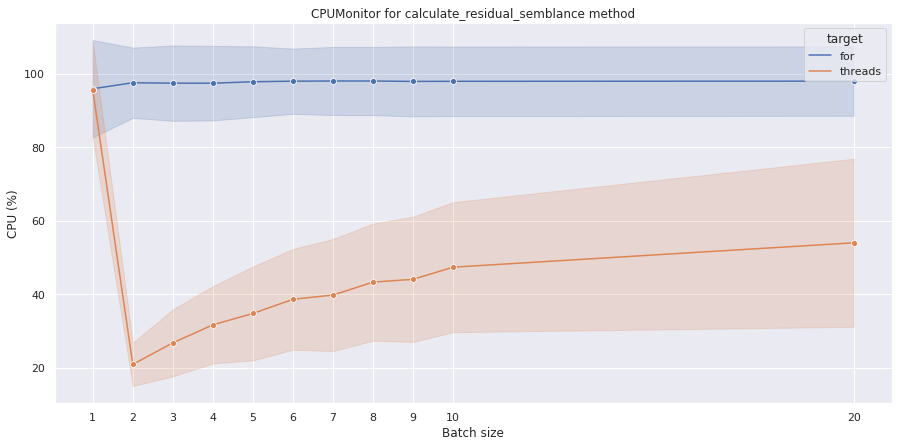

In [17]:
res_semblance_kwargs = {
    'src': 'raw', 
    'stacking_velocity': stacking_velocity,
    'n_velocities': 140, 
    'win_size': 25
}

res_semblance_bm = Benchmark(method_name='calculate_residual_semblance', method_kwargs=res_semblance_kwargs,
                             root_pipeline=sort_pipeline, **long_running_kwargs)

res_semblance_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### get_central_cdp

0it [18:00, ?it/s]3/28 [02:00<02:18,  9.25s/it]
100%|██████████| 28/28 [05:10<00:00, 11.08s/it]


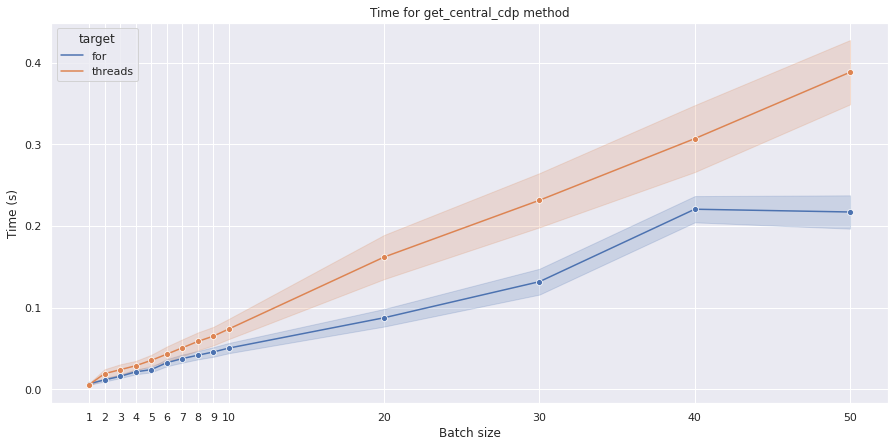

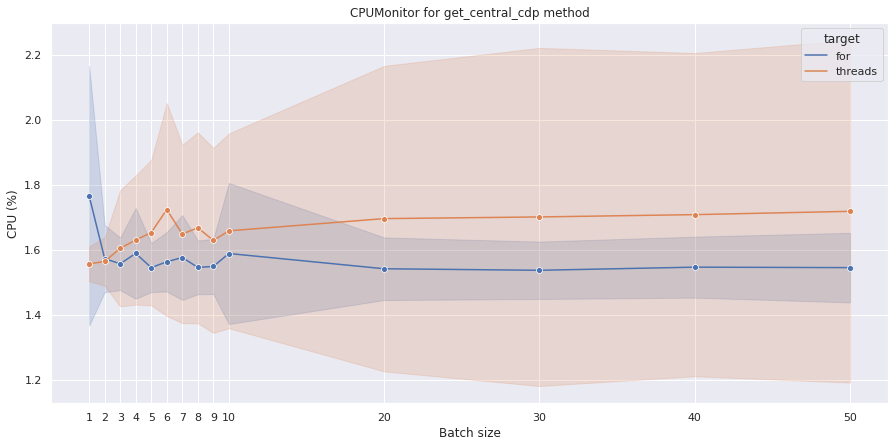

In [18]:
get_central_cdp_bm = Benchmark(method_name='get_central_cdp', method_kwargs={'src':'raw'},
                               root_pipeline=load_pipeline, **supergather_kwargs)

get_central_cdp_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### apply_nmo

0it [05:15, ?it/s]
0it [05:22, ?it/s]/28 [00:09<01:15,  3.00s/it]
0it [07:27, ?it/s]7/28 [02:06<00:04,  4.67s/it]
100%|██████████| 28/28 [02:13<00:00,  4.78s/it]
0it [07:27, ?it/s]


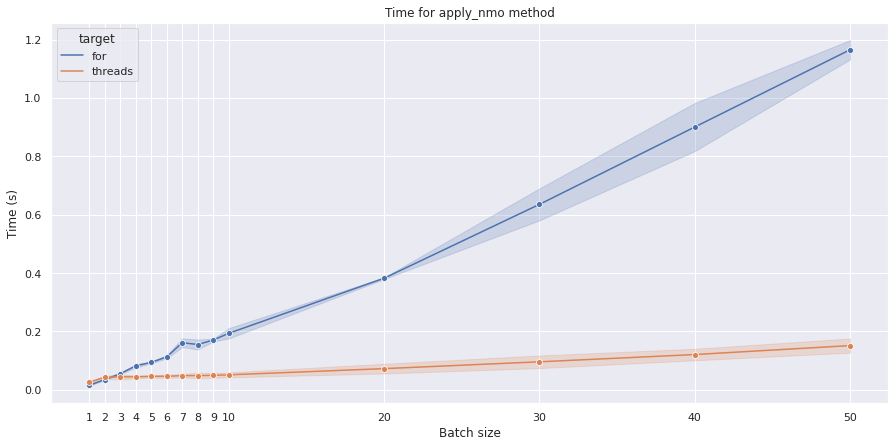

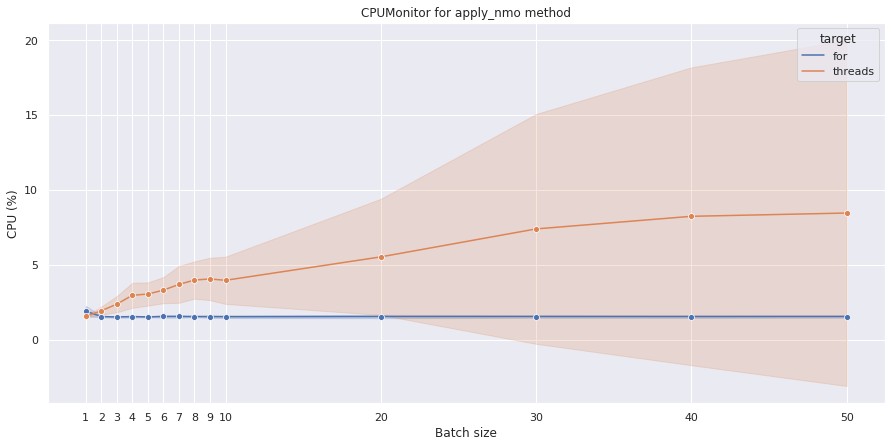

In [19]:
apply_nmo_bm = Benchmark(method_name='apply_nmo', method_kwargs={'src': 'raw', 'stacking_velocity':stacking_velocity},
                         root_pipeline=load_pipeline, **default_kwargs)
apply_nmo_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### stack

0it [04:10, ?it/s]7/28 [01:49<00:04,  4.05s/it]
100%|██████████| 28/28 [02:00<00:00,  4.31s/it]


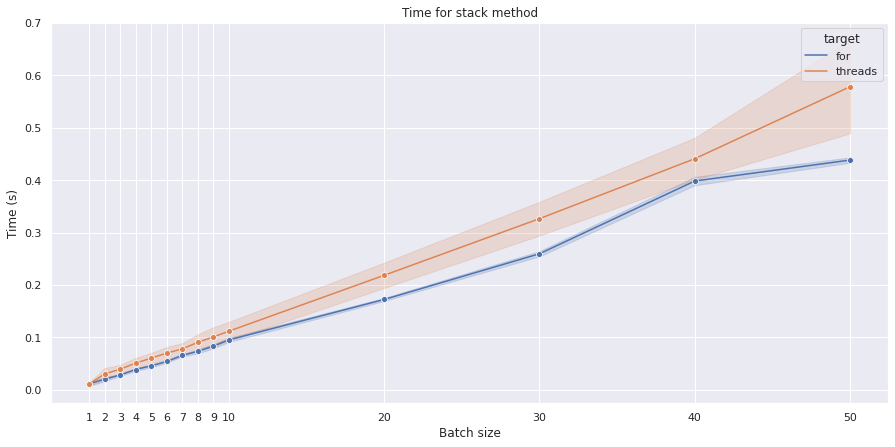

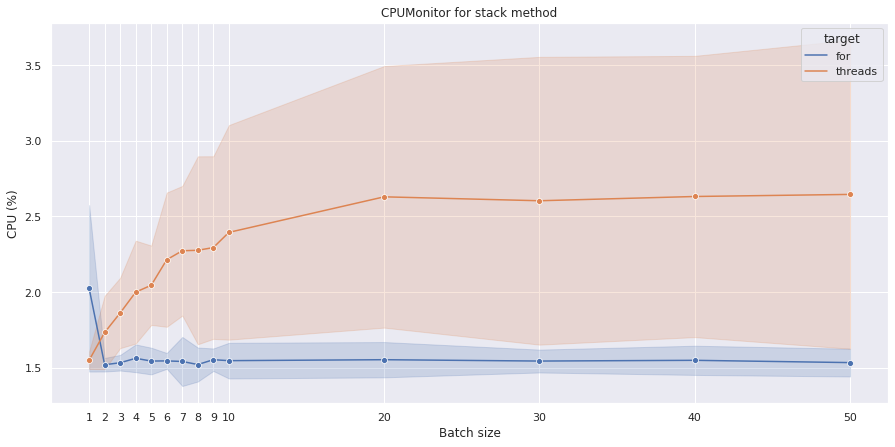

In [20]:
apply_nmo_bm = Benchmark(method_name='stack', method_kwargs={'src': 'raw'},
                         root_pipeline=load_pipeline, **default_kwargs)
apply_nmo_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_standard


0it [03:49, ?it/s]7/28 [01:40<00:03,  3.73s/it]
100%|██████████| 28/28 [01:47<00:00,  3.85s/it]


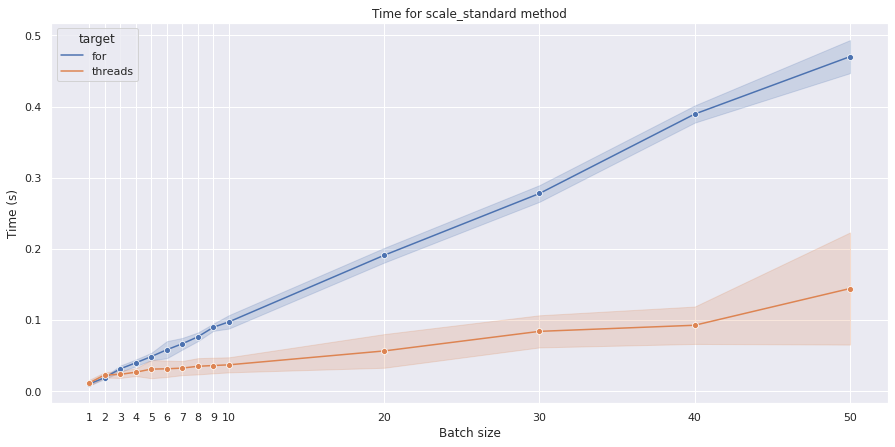

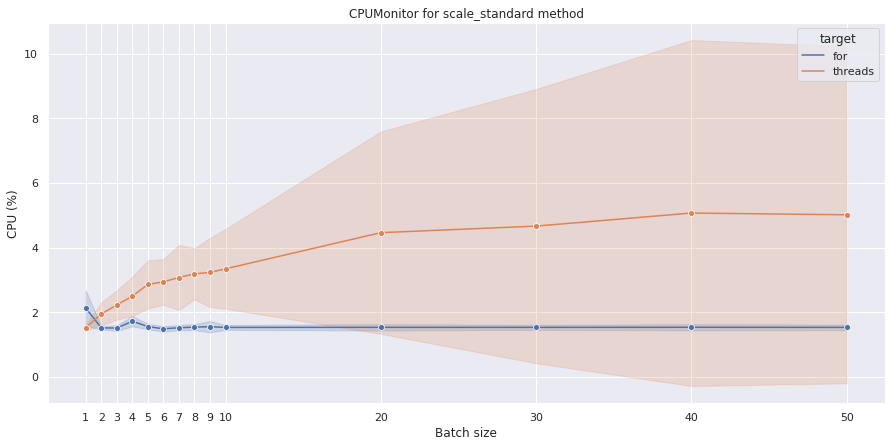

In [21]:
scale_std_bm = Benchmark(method_name='scale_standard', method_kwargs={'src':'raw'},
                         root_pipeline=load_pipeline, **default_kwargs)

scale_std_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_maxabs

100%|██████████| 22/22 [05:45<00:00, 15.71s/it]


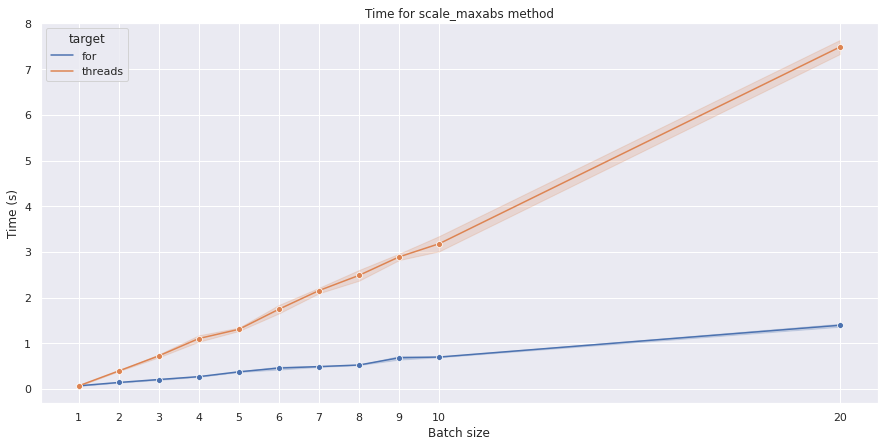

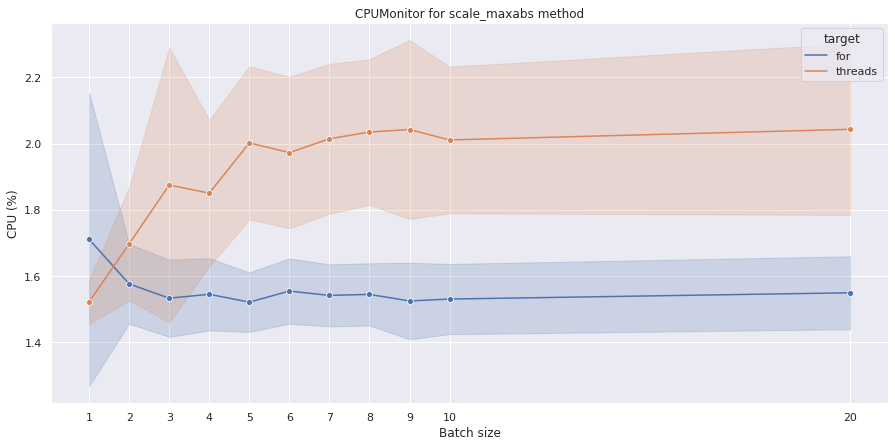

In [22]:
scale_maxabs_bm = Benchmark(method_name='scale_maxabs', method_kwargs={'src':'raw'},
                            root_pipeline=load_pipeline, **long_running_kwargs)

scale_maxabs_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### scale_minmax

100%|██████████| 22/22 [05:43<00:00, 15.59s/it]


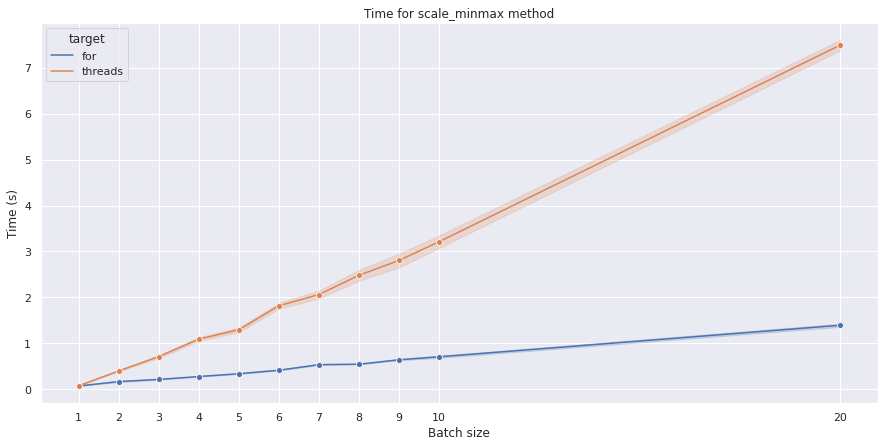

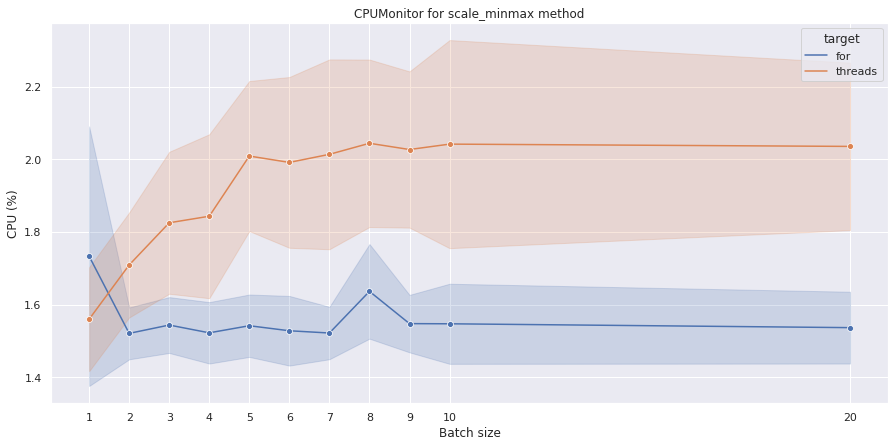

In [23]:
scale_minmax_bm = Benchmark(method_name='scale_minmax', method_kwargs={'src':'raw'},
                            root_pipeline=load_pipeline, **long_running_kwargs)

scale_minmax_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### crop

0it [13:34, ?it/s]/28 [00:07<01:05,  2.64s/it]
0it [11:44, ?it/s]
100%|██████████| 28/28 [01:31<00:00,  3.28s/it]


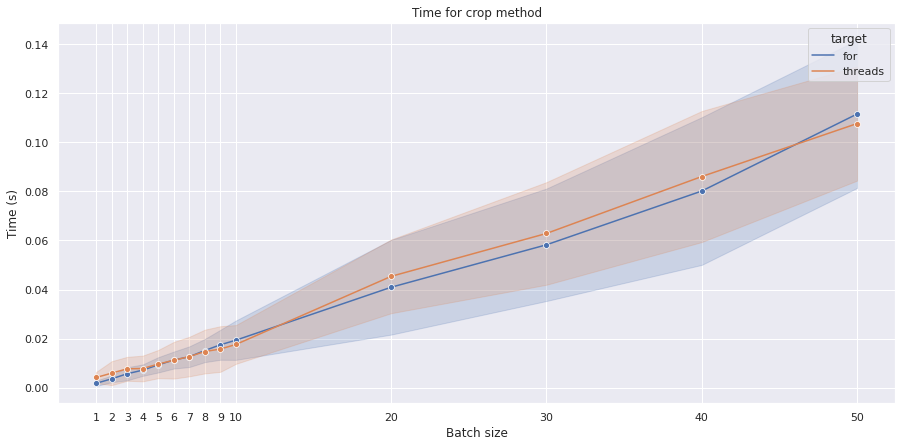

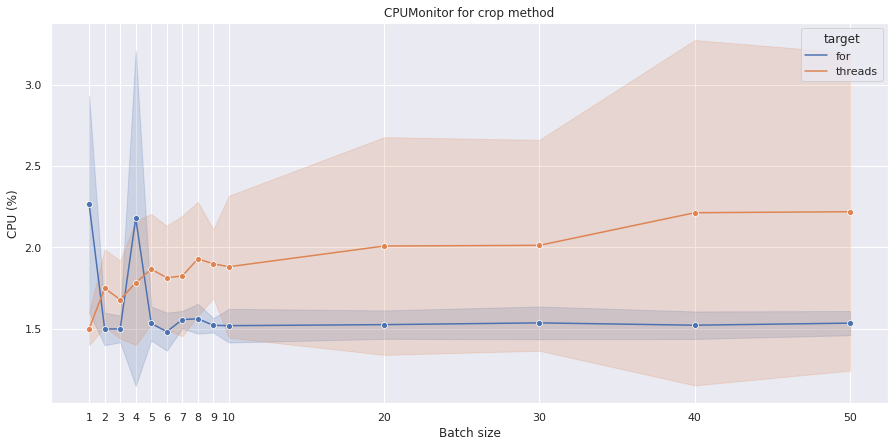

In [24]:
method_kwargs = {'src': 'raw', 'crop_shape': (200, 500), 'origins': 'random', 'n_crops': 16}

crop_bm = Benchmark(method_name='crop', method_kwargs=method_kwargs, root_pipeline=load_pipeline, **default_kwargs)

crop_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### apply_agc

0it [01:34, ?it/s]
100%|██████████| 28/28 [01:34<00:00,  3.37s/it]


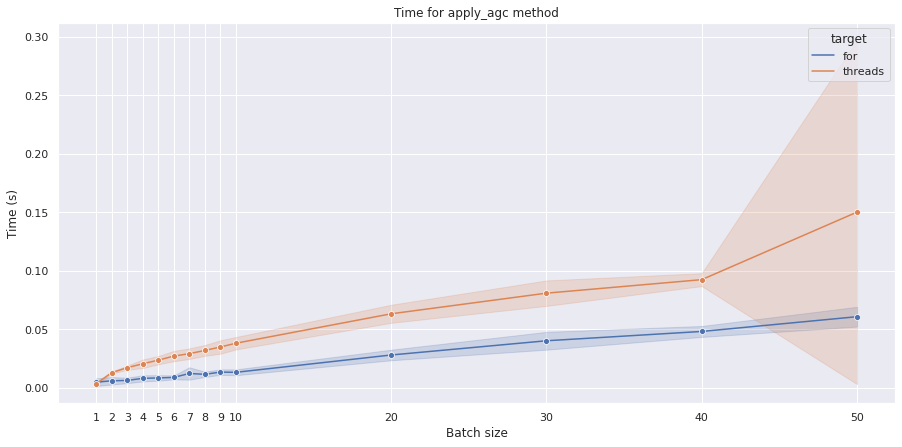

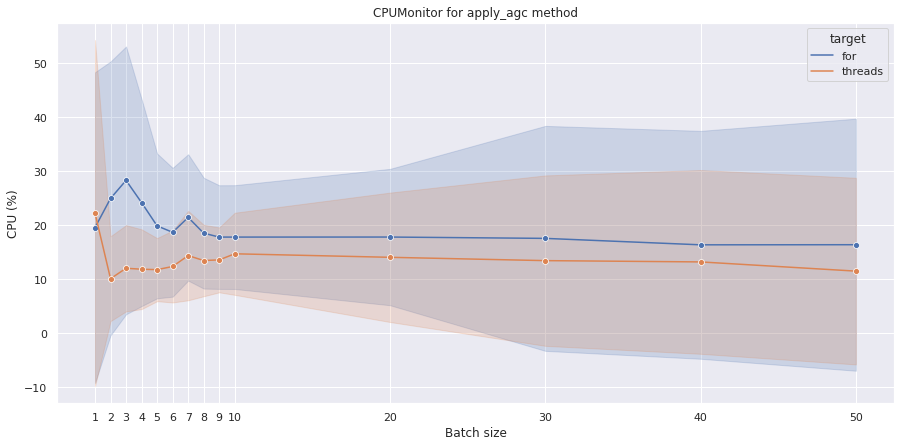

In [25]:
agc_bm = Benchmark(method_name='apply_agc', method_kwargs={'src': 'raw', 'mode':'abs'}, 
                   root_pipeline=load_pipeline, **default_kwargs)

agc_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

#### apply_sdc

100%|██████████| 28/28 [01:33<00:00,  3.35s/it]



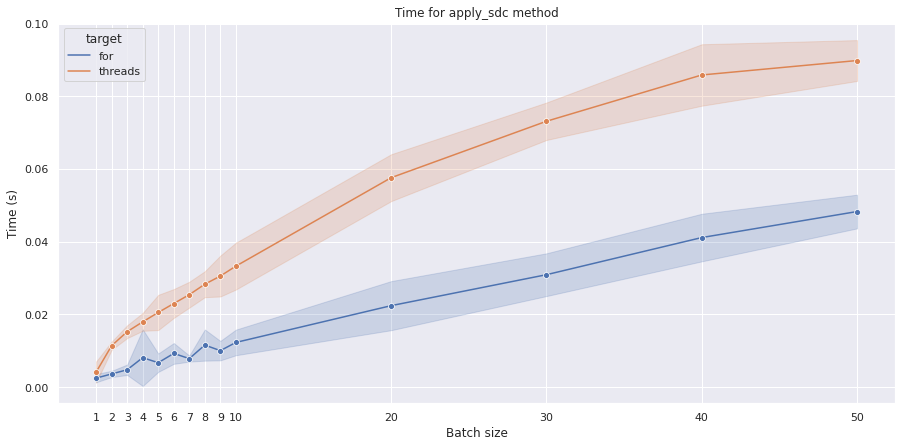

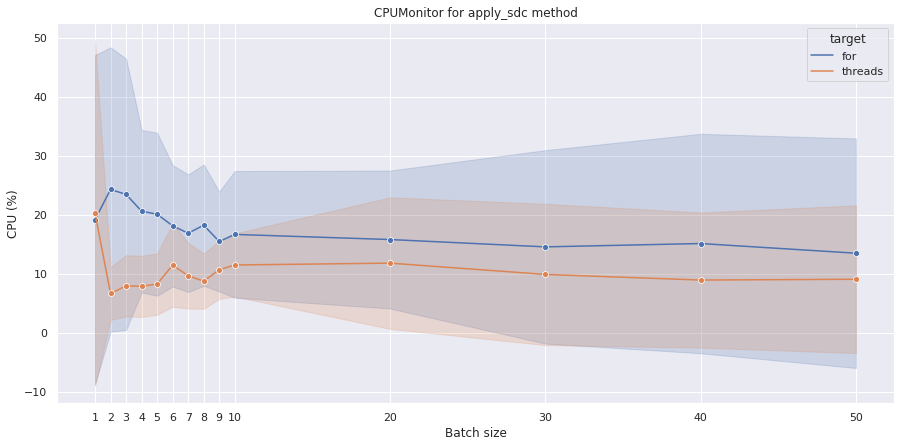

In [26]:
sdc_bm = Benchmark(method_name='apply_sdc', method_kwargs={'src': 'raw'}, 
                   root_pipeline=load_pipeline, **default_kwargs)

sdc_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### calculate_stacking_velocity

0it [01:40, ?it/s]
100%|██████████| 28/28 [31:46<00:00, 68.10s/it]


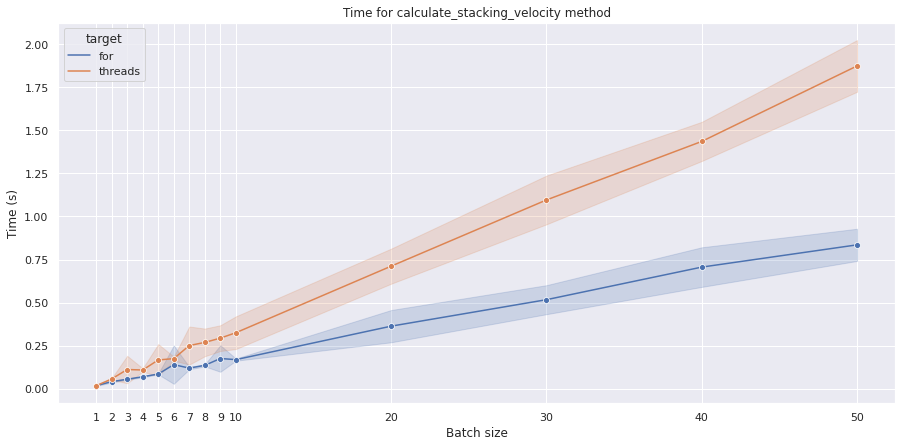

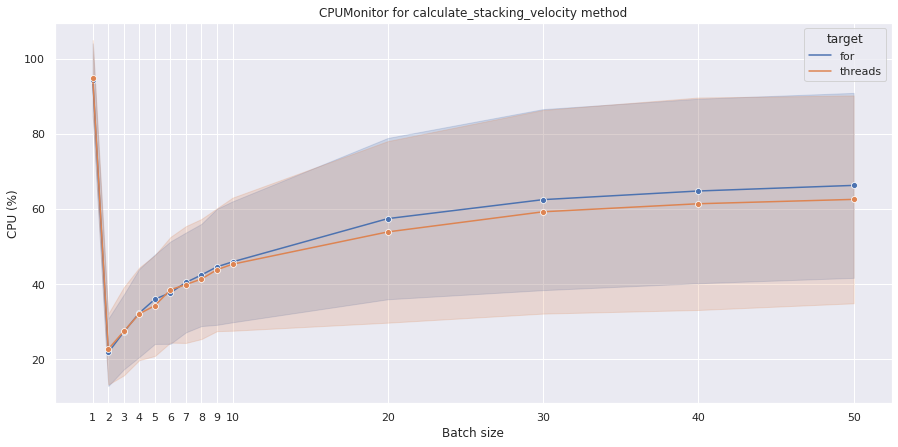

In [27]:
stacking_velocity_pipeline = sort_pipeline + Pipeline().calculate_semblance(src="raw", velocities=np.linspace(1400, 5000, 150), dst="semb")
method_kwargs = {'src': 'semb', 'start_velocity_range': (1400, 1800), 'end_velocity_range': (3500, 5000)}

stacking_velocity_bm = Benchmark(method_name='calculate_stacking_velocity', method_kwargs=method_kwargs,
                                 root_pipeline=stacking_velocity_pipeline, **default_kwargs)

stacking_velocity_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

### assemble_gather

0it [32:43, ?it/s]2/28 [00:50<01:07,  4.19s/it]
100%|██████████| 28/28 [02:20<00:00,  5.02s/it]


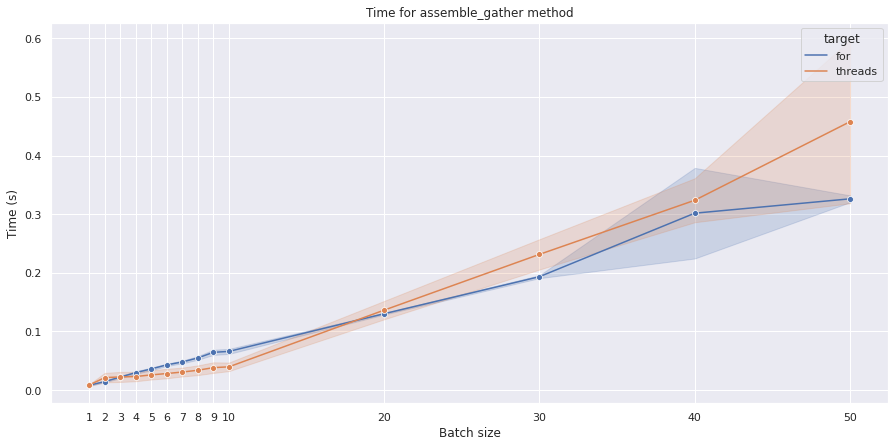

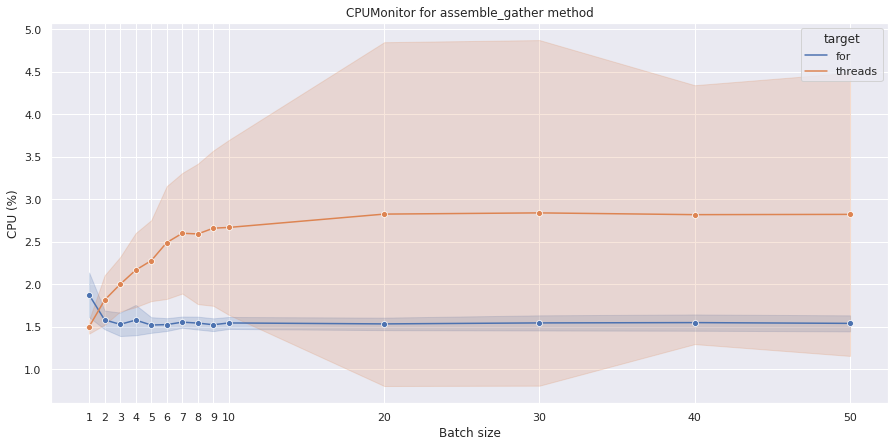

In [28]:
crop_grid_pipeline = load_pipeline + Pipeline().crop(src='raw', dst='cropped', origins='grid', crop_shape=(200, 500))

assemble_bm = Benchmark(method_name='assemble_gather', method_kwargs={'src': 'cropped'}, 
                        root_pipeline=crop_grid_pipeline, **default_kwargs)

assemble_bm.run(n_iters=N_ITERS, shuffle=SHUFFLE).plot(cpu_util=True)

Destroy temporary folder

In [30]:
tmp_dir.cleanup()